<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=146188000" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = False
cboe_years = [2019,2020,2021,2022]
load_tradier = True

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.003,0.5),
    'lp':(0.002,''),
    'sc':(0.003,0.5),
    'lc':(0.002,''),
}

configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

configs_ex_pol ={
}

configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'

configs={
    'ov':'Cumulative Return'
}

# IPV will be overwritten when data is loaded
initial_portfolio_value = 1


num_trials = 200


In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : DOS_OSSEntryP__sp:0.003_0.5_lp:0.002__sc:0.003_0.5_lc:0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_ov_Cumulative Return_230714_230921_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230831_spx_st_0_simuledge_

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:
    files = []
    for cboe_year in cboe_years:
        files.append(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_pyvollib_spx_{cboe_year}_1dte_all.csv")
        
    dfs = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)[configs['ov']]

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(configs_ent_pol['dte'], configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
study_name = get_study_name(op_sel, ent_pol_study, study_param_ranges, 
                   configs_ent_pol, ex_pol_study, configs_ex_pol,
                   configs_strat, configs, df, spx_strat_v,
                   notebook_name, notebook_v
                  )
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, configs_ent_pol['pt']), n_trials = num_trials)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-10-11 22:39:51,161] A new study created in RDB with name: DOS_OSSEntryP__sp:0.003_0.5_lp:0.002__sc:0.003_0.5_lc:0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_ov_Cumulative Return_230714_231011_spx_st_0_simuledge_0
[I 2023-10-11 22:39:56,887] Trial 0 finished with value: 1.028 and parameters: {'sp': 0.25624945091356793, 'lp': 0.2197220001214246, 'sc': 0.06971855188446069, 'lc': 0.013498854760820038}. Best is trial 0 with value: 1.028.
[I 2023-10-11 22:40:02,338] Trial 1 finished with value: -2.259 and parameters: {'sp': 0.41729021690321255, 'lp': 0.09271511928072776, 'sc': 0.20273983771601867, 'lc': 0.1826811908069928}. Best is trial 0 with value: 1.028.
[I 2023-10-11 22:40:07,857] Trial 2 finished with value: -0.455 and parameters: {'sp': 0.45325722280607006, 'lp': 0.01906019818688616, 'sc': 0.48746329896185914, 'lc': 0.38483891206630616}. Best is trial 0 with value: 1.028.
[I 2023-10-11 22:40:13,295] Trial 3 finished with value: 0.123 and parameters: {'sp': 0.

Dropping 2 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:40:46,307] Trial 9 finished with value: -0.621 and parameters: {'sp': 0.11035637835408267, 'lp': 0.047781127817245736, 'sc': 0.05452673642847408, 'lc': 0.013003455818376655}. Best is trial 6 with value: 3.991.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:40:51,814] Trial 10 finished with value: 1.09 and parameters: {'sp': 0.006361385289121467, 'lp': 0.0024932718372430787, 'sc': 0.35297794935075966, 'lc': 0.08950718928826999}. Best is trial 6 with value: 3.991.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:40:57,297] Trial 11 finished with value: 5.823 and parameters: {'sp': 0.005069330652510799, 'lp': 0.003732159489027031, 'sc': 0.3593566360211532, 'lc': 0.09276545448839743}. Bes

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:41:30,252] Trial 17 finished with value: 4.654 and parameters: {'sp': 0.3465190060154128, 'lp': 0.340231589599325, 'sc': 0.30320130731503236, 'lc': 0.2181852930817001}. Best is trial 15 with value: 9.066.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:41:35,848] Trial 18 finished with value: 0.267 and parameters: {'sp': 0.18813412170861016, 'lp': 0.18303899746820296, 'sc': 0.4264443381235046, 'lc': 0.37068983498860353}. Best is trial 15 with value: 9.066.


Dropping 5 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:41:41,294] Trial 19 finished with value: -24.056 and parameters: {'sp': 0.4985232467740714, 'lp': 0.4614442554818404, 'sc': 0.2218273056630414, 'lc': 0.19824941112532363}. Best is trial 15 with value: 9.066.


Dropping 7 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:41:46,787] Trial 20 finished with value: -31.693 and parameters: {'sp': 0.3419724696149212, 'lp': 0.2792969045952301, 'sc': 0.49786490117431226, 'lc': 0.46457213206088976}. Best is trial 15 with value: 9.066.


Dropping 8 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:41:52,293] Trial 21 finished with value: 11.206 and parameters: {'sp': 0.29677188640409874, 'lp': 0.2638858272004656, 'sc': 0.40576128583409593, 'lc': 0.24983487188905873}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:41:57,772] Trial 22 finished with value: 7.851 and parameters: {'sp': 0.2255219670001004, 'lp': 0.22396572900653527, 'sc': 0.40611349868402147, 'lc': 0.27069230896218216}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:42:03,215] Trial 23 finished with value: -4.321 and parameters: {'sp': 0.21931141301160745, 'lp': 0.204415418044075, 'sc': 0.304757784245588, 'lc': 0.26574802353080534}. Best is trial 21 with value: 11.206.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:42:08,771] Trial 24 finished with value: -20.021 and parameters: {'sp': 0.2206290420688544, 'lp': 0.14311035074688574, 'sc': 0.43343638749881674, 'lc': 0.3192656343863733}. Best is trial 21 with value: 11.206.


Dropping 7 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:42:14,252] Trial 25 finished with value: -4.537 and parameters: {'sp': 0.3818069872295304, 'lp': 0.24905122777353406, 'sc': 0.32905854005839985, 'lc': 0.23077464722783075}. Best is trial 21 with value: 11.206.


Dropping 5 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:42:19,729] Trial 26 finished with value: -7.865 and parameters: {'sp': 0.29737682022418077, 'lp': 0.2463354303010743, 'sc': 0.4610900770989375, 'lc': 0.3166581303398348}. Best is trial 21 with value: 11.206.


Dropping 8 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:42:25,290] Trial 27 finished with value: -7.862 and parameters: {'sp': 0.22277637967450162, 'lp': 0.14846019126218352, 'sc': 0.4004248445294569, 'lc': 0.2907809247279723}. Best is trial 21 with value: 11.206.


Dropping 3 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-10-11 22:42:30,759] Trial 28 finished with value: 5.782 and parameters: {'sp': 0.3702549858286851, 'lp': 0.33251522802503775, 'sc': 0.0031478737451602345, 'lc': 0.0031418227760436346}. Best is trial 21 with value: 11.206.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:42:36,305] Trial 29 finished with value: 3.225 and parameters: {'sp': 0.2559879768954306, 'lp': 0.22293560385736413, 'sc': 0.17713860265496037, 'lc': 0.16811769983358582}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:42:41,797] Trial 30 f

Dropping 5 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:42:47,348] Trial 31 finished with value: 8.87 and parameters: {'sp': 0.31476912303053295, 'lp': 0.29068595015463283, 'sc': 0.40769155623428327, 'lc': 0.23189576851794227}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:42:52,894] Trial 32 finished with value: -17.191 and parameters: {'sp': 0.3112834533380952, 'lp': 0.28586631751286273, 'sc': 0.4589095391090325, 'lc': 0.3545966375303552}. Best is trial 21 with value: 11.206.


Dropping 8 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:42:58,390] Trial 33 finished with value: 7.159 and parameters: {'sp': 0.24344722293809015, 'lp': 0.24215157224895506, 'sc': 0.4078430870533339, 'lc': 0.1768649397144664}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:43:03,874] Trial 34 finished with value: -10.385 and parameters: {'sp': 0.41010620888450355, 'lp': 0.368919983645984, 'sc': 0.33729915866960886, 'lc': 0.2450983041027003}. Best is trial 21 with value: 11.206.


Dropping 4 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:43:09,393] Trial 35 finished with value: -10.194 and parameters: {'sp': 0.36991697376524046, 'lp': 0.2988923547189992, 'sc': 0.29842875609197994, 'lc': 0.21100283522345084}. Best is trial 21 with value: 11.206.


Dropping 9 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:43:14,885] Trial 36 finished with value: 0.763 and parameters: {'sp': 0.18988342337620523, 'lp': 0.18277231283233383, 'sc': 0.48089760852975927, 'lc': 0.4117078132860542}. Best is trial 21 with value: 11.206.


Dropping 8 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:43:20,394] Trial 37 finished with value: -42.105 and parameters: {'sp': 0.46349346118461854, 'lp': 0.3964249635357823, 'sc': 0.27911535382349806, 'lc': 0.22718058086202675}. Best is trial 21 with value: 11.206.


Dropping 19 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:43:25,991] Trial 38 finished with value: 6.859 and parameters: {'sp': 0.4376931229981015, 'lp': 0.26932433231755204, 'sc': 0.2266256710890488, 'lc': 0.11669658387329664}. Best is trial 21 with value: 11.206.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:43:31,470] Trial 39 finished with value: 6.413 and parameters: {'sp': 0.2529109847794926, 'lp': 0.21774647490081867, 'sc': 0.38472843435338244, 'lc': 0.2855654384052229}. Best is trial 21 with value: 11.206.


Dropping 2 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:43:36,965] Trial 40 finished with value: 5.811 and parameters: {'sp': 0.30973536687209097, 'lp': 0.26533280726628067, 'sc': 0.43745280809763726, 'lc': 0.1507373110454556}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:43:42,439] Trial 41 finished with value: 8.202 and parameters: {'sp': 0.32297760745180176, 'lp': 0.2924474645669817, 'sc': 0.41685095744732886, 'lc': 0.24975965475291326}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:43:47,955] Trial 42 finished with value: 8.589 and parameters: {'sp': 0.36081804061164563, 'lp': 0.31283158557753965, 'sc': 0.4151399319403731, 'lc': 0.26822505406594443}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:43:53,463] Trial 43 finished with value: -7.002 and parameters: {'sp': 0.3551902236743309, 'lp': 0.3168664339461272, 'sc': 0.4801065835920309, 'lc': 0.34682381875333407}. Best is trial 21 with value: 11.206.


Dropping 9 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:43:59,037] Trial 44 finished with value: -24.588 and parameters: {'sp': 0.38182714677184565, 'lp': 0.3066069958528195, 'sc': 0.3588601517009512, 'lc': 0.24717764987167468}. Best is trial 21 with value: 11.206.


Dropping 19 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:44:04,513] Trial 45 finished with value: -7.747 and parameters: {'sp': 0.3975575777825613, 'lp': 0.3588933151849262, 'sc': 0.4214577950820372, 'lc': 0.30573341571104606}. Best is trial 21 with value: 11.206.


Dropping 5 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:44:09,965] Trial 46 finished with value: 8.268 and parameters: {'sp': 0.2845349905869835, 'lp': 0.2641571948826693, 'sc': 0.45243880819785154, 'lc': 0.19590407035423107}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:44:15,435] Trial 47 finished with value: 8.859 and parameters: {'sp': 0.2866578642184512, 'lp': 0.2607948084620149, 'sc': 0.45169257089237624, 'lc': 0.15599166016436888}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:44:20,910] Trial 48 finished with value: 5.495 and parameters: {'sp': 0.430936091017024, 'lp': 0.3827389815930168, 'sc': 0.34621388983567036, 'lc': 0.0640915723267324}. Best is trial 21 with value: 11.206.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:44:26,406] Trial 49 finished with value: 4.702 and parameters: {'sp': 0.2672057131755563, 'lp': 0.2469878873339424, 'sc': 0.3866252306

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:46:39,017] Trial 73 finished with value: -10.224 and parameters: {'sp': 0.3903285247956346, 'lp': 0.3227679398259501, 'sc': 0.3901925354898194, 'lc': 0.2619201142188469}. Best is trial 21 with value: 11.206.


Dropping 6 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:46:44,518] Trial 74 finished with value: 2.378 and parameters: {'sp': 0.3261291748479734, 'lp': 0.2739093467705774, 'sc': 0.16283479428564313, 'lc': 0.14029911568133513}. Best is trial 21 with value: 11.206.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:46:50,033] Trial 75 finished with value: 3.889 and parameters: {'sp': 0.29868987054915086, 'lp': 0.28589035915679495, 'sc': 0.3716431484915444, 'lc': 0.23224412275939033}. Best is trial 21 with value: 11.206.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:46:55,556] Trial 76 finished with value: 7.477 and parameters: {'sp': 0.2358461829995584, 'lp': 0.2307725724474683, 'sc': 0.4056562116357385, 'lc': 0.18886033755140524}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:47:01,031] Trial 77 finished with value: -27.332 and parameters: {'sp': 0.3648836393061453, 'lp': 0.32526251975865816, 'sc': 0.3195632759176148, 'lc': 0.2582715200948142}. Best is trial 21 with value: 11.206.


Dropping 13 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:47:06,692] Trial 78 finished with value: 5.084 and parameters: {'sp': 0.2759754370295874, 'lp': 0.27119455400865816, 'sc': 0.44063570508748406, 'lc': 0.20501953663033448}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:47:12,203] Trial 79 finished with value: 7.258 and parameters: {'sp': 0.3173399331460031, 'lp': 0.3015704553975959, 'sc': 0.48547739006719126, 'lc': 0.17239099380288836}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:47:17,718] Trial 80 finished with value: 8.148 and parameters: {'sp': 0.3407053774200258, 'lp': 0.288395688203465, 'sc': 0.4666160327947556, 'lc': 0.09924258795017682}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:47:23,254] Trial 81 finished with value: -7.88 and parameters: {'sp': 0.3619807797711323, 'lp': 0.3075935078203481, 'sc': 0.415897194

Dropping 9 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:47:28,825] Trial 82 finished with value: 4.333 and parameters: {'sp': 0.38662525983128887, 'lp': 0.34980972093421514, 'sc': 0.4118727542002026, 'lc': 0.2819594693426576}. Best is trial 21 with value: 11.206.


Dropping 3 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:47:34,300] Trial 83 finished with value: -2.208 and parameters: {'sp': 0.4152178736363586, 'lp': 0.3138702913357908, 'sc': 0.42565462653522, 'lc': 0.2391821640575494}. Best is trial 21 with value: 11.206.


Dropping 7 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:47:39,880] Trial 84 finished with value: -4.836 and parameters: {'sp': 0.36003187078455934, 'lp': 0.3276292234730891, 'sc': 0.45021440761349324, 'lc': 0.30661249422664877}. Best is trial 21 with value: 11.206.


Dropping 7 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:47:45,375] Trial 85 finished with value: 5.566 and parameters: {'sp': 0.3009901459895869, 'lp': 0.2909152999654291, 'sc': 0.365863784802412, 'lc': 0.2203750868214796}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:47:50,917] Trial 86 finished with value: 7.539 and parameters: {'sp': 0.3301841390685719, 'lp': 0.3114779490376302, 'sc': 0.3969123297673298, 'lc': 0.13059295585075228}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:47:56,461] Trial 87 finished with value: -20.096 and parameters: {'sp': 0.3497557200062596, 'lp': 0.27576117840472, 'sc': 0.4838652459404855, 'lc': 0.32576521354806054}. Best is trial 21 with value: 11.206.


Dropping 15 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:48:01,988] Trial 88 finished with value: 5.755 and parameters: {'sp': 0.3099192028955874, 'lp': 0.29836880809194977, 'sc': 0.43642453338008735, 'lc': 0.2477646396961451}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:48:07,622] Trial 89 finished with value: 5.412 and parameters: {'sp': 0.37365818694850644, 'lp': 0.3587373617708739, 'sc': 0.34803514491109844, 'lc': 0.238815839193312}. Best is trial 21 with value: 11.206.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:48:13,090] Trial 90 finished with value: 9.938 and parameters: {'sp': 0.28707417016237025, 'lp': 0.2793913669398971, 'sc': 0.45790998995159077, 'lc': 0.2925315747581833}. Best is trial 21 with value: 11.206.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:48:18,640] Trial 91 finished with value: 1.2 and parameters: {'sp': 0.2671362034301285, 'lp': 0.22865144459852005, 'sc': 0.45537046911671036, 'lc': 0.2994933685973703}. Best is trial 21 with value: 11.206.


Dropping 3 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:48:24,092] Trial 92 finished with value: 8.464 and parameters: {'sp': 0.28936786621804805, 'lp': 0.2835876165792655, 'sc': 0.46711432675504844, 'lc': 0.2684270540961018}. Best is trial 21 with value: 11.206.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:48:29,595] Trial 93 finished with value: 4.241 and parameters: {'sp': 0.24523207786878357, 'lp': 0.23629937328160133, 'sc': 0.4245789651011838, 'lc': 0.3282459421363289}. Best is trial 21 with value: 11.206.


Dropping 3 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:48:35,111] Trial 94 finished with value: 6.387 and parameters: {'sp': 0.3169969487911323, 'lp': 0.2961375208892074, 'sc': 0.4092664644708201, 'lc': 0.2564400009189524}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:48:40,713] Trial 95 finished with value: -22.929 and parameters: {'sp': 0.43012997062504116, 'lp': 0.2091546365862953, 'sc': 0.4898211938750152, 'lc': 0.27945477423627424}. Best is trial 21 with value: 11.206.


Dropping 15 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:48:46,257] Trial 96 finished with value: 8.415 and parameters: {'sp': 0.3402050310853318, 'lp': 0.2615606073511981, 'sc': 0.4737985150767604, 'lc': 0.160220633044104}. Best is trial 21 with value: 11.206.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:48:51,741] Trial 97 finished with value: 8.125 and parameters: {'sp': 0.2999240616143479, 'lp': 0.2998638181716862, 'sc': 0.45796381372574846, 'lc': 0.22105979436506362}. Best is trial 21 with value: 11.206.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:48:57,249] Trial 98 finished with value: 9.465 and parameters: {'sp': 0.2549103333326487, 'lp': 0.23895951433825066, 'sc': 0.3834016230692585, 'lc': 0.14591445420918162}. Best is trial

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:49:30,293] Trial 104 finished with value: 4.324 and parameters: {'sp': 0.32693571178500974, 'lp': 0.2679129215728967, 'sc': 0.44643525830227554, 'lc': 0.26455182610226113}. Best is trial 21 with value: 11.206.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:49:35,840] Trial 105 finished with value: 6.123 and parameters: {'sp': 0.2260172594133218, 'lp': 0.21613546819220725, 'sc': 0.3775164218150398, 'lc': 0.15333953884652407}. Best is trial 21 with value: 11.206.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:49:41,380] Trial 106 finished with value: 6.569 and parameters: {'sp': 0.29142572758705365, 'lp': 0.2865523679272443, 'sc': 0.4746848027179338, 'lc': 0.10820487594395743}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:49:46,896] Trial 107 finished with value: 5.103 and parameters: {'sp': 0.35222676093918165, 'lp': 0.320015321501843, 'sc': 0.41540054535939736, 'lc': 0.16647084340774104}. Best is

Dropping 10 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:50:42,146] Trial 117 finished with value: 8.935 and parameters: {'sp': 0.3944055260766446, 'lp': 0.3361594445580935, 'sc': 0.46481582892247175, 'lc': 0.13969921467938712}. Best is trial 21 with value: 11.206.
[I 2023-10-11 22:50:47,793] Trial 118 finished with value: 11.946 and parameters: {'sp': 0.3915347246387366, 'lp': 0.23839390452505, 'sc': 0.46190062471082804, 'lc': 0.14929618070353065}. Best is trial 118 with value: 11.946.
[I 2023-10-11 22:50:53,255] Trial 119 finished with value: 9.909 and parameters: {'sp': 0.3948258742348422, 'lp': 0.33821433221956904, 'sc': 0.46541561556080413, 'lc': 0.14303303644079324}. Best is trial 118 with value: 11.946.
[I 2023-10-11 22:50:58,752] Trial 120 finished with value: 9.763 and parameters: {'sp': 0.3935947627273849, 'lp': 0.33720478756367367, 'sc': 0.4647860498365852, 'lc': 0.1419211893536992}. Best is trial 118 with value: 11.946.
[I 2023-10-11 22:51:04,317] Trial 121 finished with value: 9.628 and parameters: {'sp': 0.3982

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:53:49,642] Trial 151 finished with value: 12.491 and parameters: {'sp': 0.44359164851346833, 'lp': 0.35367672864413174, 'sc': 0.47776411155712145, 'lc': 0.17504887081213807}. Best is trial 143 with value: 14.771.
[I 2023-10-11 22:53:55,206] Trial 152 finished with value: 11.405 and parameters: {'sp': 0.4355521517553144, 'lp': 0.35362810201793876, 'sc': 0.49206276182506686, 'lc': 0.17854290385708216}. Best is trial 143 with value: 14.771.
[I 2023-10-11 22:54:00,712] Trial 153 finished with value: 9.715 and parameters: {'sp': 0.4479387786005593, 'lp': 0.3930031563676424, 'sc': 0.49963883992075186, 'lc': 0.1820896816593202}. Best is trial 143 with value: 14.771.
[I 2023-10-11 22:54:06,376] Trial 154 finished with value: 12.287 and parameters: {'sp': 0.43169841498239686, 'lp': 0.3520391651435372, 'sc': 0.48218294930981065, 'lc': 0.19721786681636153}. Best is trial 143 with value: 14.771.
[I 2023-10-11 22:54:11,870] Trial 155 finished with value: 10.536 and parameters: {'sp

Dropping 6 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:55:12,473] Trial 166 finished with value: 14.027 and parameters: {'sp': 0.4523211647002729, 'lp': 0.35006276707429834, 'sc': 0.47715140758436037, 'lc': 0.18404066789956355}. Best is trial 143 with value: 14.771.
[I 2023-10-11 22:55:18,009] Trial 167 finished with value: 13.929 and parameters: {'sp': 0.4309426227139014, 'lp': 0.33236507903968493, 'sc': 0.476868427883301, 'lc': 0.18826562051080237}. Best is trial 143 with value: 14.771.
[I 2023-10-11 22:55:23,516] Trial 168 finished with value: 10.947 and parameters: {'sp': 0.42925874519317686, 'lp': 0.3291937213378841, 'sc': 0.4995955703648271, 'lc': 0.1914526129838314}. Best is trial 143 with value: 14.771.
[I 2023-10-11 22:55:29,088] Trial 169 finished with value: 9.714 and parameters: {'sp': 0.45141629373455433, 'lp': 0.37878324987175005, 'sc': 0.47693757481894405, 'lc': 0.20947212654113379}. Best is trial 143 with value: 14.771.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: Run

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:56:24,223] Trial 179 finished with value: 13.06 and parameters: {'sp': 0.4302090709616908, 'lp': 0.3329098009745277, 'sc': 0.48127386774525, 'lc': 0.1876884975006381}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:56:29,814] Trial 180 finished with value: 10.348 and parameters: {'sp': 0.457756288944633, 'lp': 0.3338794584589085, 'sc': 0.48291392862082, 'lc': 0.18691819965135684}. Best is trial 175 with value: 14.84.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:56:35,378] Trial 181 finished with value: 12.345 and parameters: {'sp': 0.43126175075277345, 'lp': 0.3323464610091385, 'sc': 0.4671722452605852, 'lc': 0.20647525436222194}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:56:40,898] Trial 182 finished with value: 13.948 and parameters: {'sp': 0.43461246830636374, 'lp': 0.32328062288745163, 'sc': 0.46672120335216694, 'lc': 0.18723850466744887}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:56:46,499] Trial 183 finished with value: 11.636 and parameters: {'sp': 0.43604250942410616, 'lp': 0.3308244048745115, 'sc': 0.46877365067244864, 'lc': 0.1902847340747027}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:56:51,987] Trial 184 finished with value: 6.47 and parameters: {'sp': 0.42484186907884375, 'lp': 0.3227765269809984, 'sc': 0.48228883513678966, 'lc': 0.21660440250806984}. Best is trial 175 with value: 14.84.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:56:57,524] Trial 185 finished with value: 8.713 and parameters: {'sp': 0.4564378108996469, 'lp': 0.3326317766364741, 'sc': 0.4593723883992189, 'lc': 0.19823476372897975}. Best is trial 175 with value: 14.84.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:57:03,056] Trial 186 finished with value: 11.88 and parameters: {'sp': 0.4138207377226233, 'lp': 0.3429864360930375, 'sc': 0.47297413951113665, 'lc': 0.17790995306250426}. Best is trial 175 with value: 14.84.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-10-11 22:57:08,573] Trial 187 finished with value: 1.85 and parameters: {'sp': 0.4376899959378561, 'lp': 0.3566829880827935, 'sc': 0.12055054631584569, 'lc': 0.12022275392680248}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:57:14,085] Trial 188 finished with value: -19.839 and parameters: {'sp': 0.4675312348289234, 'lp': 0.327684025545222, 'sc': 0.4839575409048237, 'lc': 0.4145499981980113}. Best is trial 175 with value: 1

Dropping 11 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:57:19,562] Trial 189 finished with value: 12.212 and parameters: {'sp': 0.42940314836838606, 'lp': 0.34476677437402264, 'sc': 0.46555467006393225, 'lc': 0.21033750306672194}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:57:25,070] Trial 190 finished with value: 10.506 and parameters: {'sp': 0.4505058538848699, 'lp': 0.34551947104740754, 'sc': 0.4616212907033619, 'lc': 0.21081624591519602}. Best is trial 175 with value: 14.84.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:57:30,573] Trial 191 finished with value: 10.845 and parameters: {'sp': 0.42354740754189896, 'lp': 0.35758660402759174, 'sc': 0.4724364162532755, 'lc': 0.1881264281783444}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:57:36,199] Trial 192 finished with value: 11.253 and parameters: {'sp': 0.43445512084827076, 'lp': 0.31874415660528943, 'sc': 0.48785920364269253, 'lc': 0.17146228423357734}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:57:41,679] Trial 193 finished with value: 13.685 and parameters: {'sp': 0.43977416822319443, 'lp': 0.3442022376631721, 'sc': 0.4679169356472721, 'lc': 0.1999820313364904}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:57:47,191] Trial 194 finished with value: 10.229 and parameters: {'sp': 0.44398832545557265, 'lp': 0.370753673161866, 'sc': 0.45735607518767063, 'lc': 0.19866346523716852}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:57:52,777] Trial 195 finished with value: 10.454 and parameters: {'sp': 0.

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 22:57:58,324] Trial 196 finished with value: 10.327 and parameters: {'sp': 0.41403490069953536, 'lp': 0.35605798304153635, 'sc': 0.4795416206715561, 'lc': 0.1804514326597063}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:58:03,852] Trial 197 finished with value: 13.494 and parameters: {'sp': 0.4411650502179528, 'lp': 0.3483144851698562, 'sc': 0.46525328467980265, 'lc': 0.19718105489272633}. Best is trial 175 with value: 14.84.
[I 2023-10-11 22:58:09,429] Trial 198 finished with value: 9.607 and parameters: {'sp': 0.43922310506013673, 'lp': 0.36222084867168264, 'sc': 0.44363443709095535, 'lc': 0.19795547196054347}. Best is trial 175 with value: 14.84.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 22:58:14,929] Trial 199 finished with value: 3.016 and parameters: {'sp': 0.47126367656617163, 'lp': 0.33824037338387275, 'sc': 

Best Score:  14.84
Best Params: 
  lc: 0.18715362328521534
  lp: 0.34947803697787805
  sc: 0.47990399870008094
  sp: 0.43239020583883786


# Backtest with current best score

*****  BACKTEST RESULTS  ****
Cumulative Return                                 14.84
Max Drawdown                                     -2.315
Mean Net Max Loss                              1615.323
Max Net Max Loss                                 2380.0
Mean Return on Max Risk                           0.115
Std Dev of Return on Max Risk                     0.603
Risk Adj Cumulative Return On Scaled Max Risk     24.61
Trading Days                                         62
Wins                                                 43
Losses                                               19
Breakeven                                             0
Win/Loss Ratio                                   69.355
Mean Win                                        723.384
Mean Loss                                     -1126.974
Mean Net Trans                                  156.339
Std Dev of Net Trans                           1002.837
Max Loss                                        -2386.0
Max Win           

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,4500.0,4510.0,4530.0,4490.0,0.43239,0.427478,817.5,0.479904,0.419038,780.0,0.187154,0.165769,-230.0,0.349478,0.286450,-472.5,895.0,1669.0,0.0,4526.69,6.0,1669.0,-780.0,89420.8,-780.0,NaN,-0.008647,0.000207,2000.0,1105.0,-0.705882,0.985882
1,2023-07-17,2023-07-18,4.0,4520.0,4530.0,4550.0,4515.0,0.43239,0.401656,860.0,0.479904,0.446068,642.5,0.187154,0.147009,-165.0,0.349478,0.333631,-640.0,697.5,2000.0,0.0,4558.32,6.0,2000.0,-1308.5,88112.3,-2088.5,-0.014633,-0.023154,0.000208,2000.0,1302.5,-1.004607,0.979908
2,2023-07-18,2023-07-19,4.0,4550.0,4565.0,4580.0,4545.0,0.43239,0.374783,740.0,0.479904,0.394381,617.5,0.187154,0.185865,-240.0,0.349478,0.304246,-535.0,582.5,348.0,0.0,4568.48,6.0,348.0,228.5,88340.8,-1860.0,0.002593,-0.020621,0.000208,1500.0,917.5,0.249046,1.004981
3,2023-07-19,2023-07-20,4.0,4560.0,4575.0,4600.0,4555.0,0.43239,0.378607,790.0,0.479904,0.418772,855.0,0.187154,0.144899,-217.5,0.349478,0.311034,-582.5,845.0,0.0,500.0,4534.01,6.0,500.0,339.0,88679.8,-1521.0,0.003837,-0.016862,0.000208,2500.0,1655.0,0.204834,1.004097
4,2023-07-20,2023-07-21,4.0,4530.0,4540.0,4565.0,4520.0,0.43239,0.427143,815.0,0.479904,0.430633,942.5,0.187154,0.158887,-250.0,0.349478,0.288242,-482.5,1025.0,0.0,0.0,4537.79,6.0,0.0,1019.0,89698.8,-502.0,0.011491,-0.005565,0.000208,2500.0,1475.0,0.690847,1.013817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023-10-04,2023-10-05,4.0,4255.0,4270.0,4300.0,4245.0,0.43239,0.396833,1145.0,0.479904,0.452511,1270.0,0.187154,0.174236,-340.0,0.349478,0.311509,-850.0,1225.0,0.0,0.0,4259.48,6.0,0.0,1219.0,102329.8,12129.0,0.012056,0.134467,0.000212,3000.0,1775.0,0.686761,1.013735
58,2023-10-05,2023-10-06,4.0,4250.0,4265.0,4305.0,4240.0,0.43239,0.419935,1605.0,0.479904,0.460351,1620.0,0.187154,0.168192,-412.5,0.349478,0.344574,-1192.5,1620.0,4000.0,0.0,4318.04,6.0,4000.0,-2386.0,99943.8,9743.0,-0.023317,0.108015,0.000211,4000.0,2380.0,-1.002521,0.979950
59,2023-10-06,2023-10-09,4.0,4310.0,4325.0,4350.0,4295.0,0.43239,0.425612,1730.0,0.479904,0.427933,855.0,0.187154,0.163984,-265.0,0.349478,0.312415,-1050.0,1270.0,533.0,0.0,4330.33,6.0,533.0,731.0,100674.8,10474.0,0.007314,0.116119,0.000212,2500.0,1230.0,0.594309,1.011886
60,2023-10-09,2023-10-10,4.0,4325.0,4335.0,4370.0,4315.0,0.43239,0.422968,975.0,0.479904,0.464743,1525.0,0.187154,0.156288,-310.0,0.349478,0.314176,-682.5,1507.5,2667.0,0.0,4361.67,6.0,2667.0,-1165.5,99509.3,9308.5,-0.011577,0.103198,0.000212,3500.0,1992.5,-0.584944,0.988301


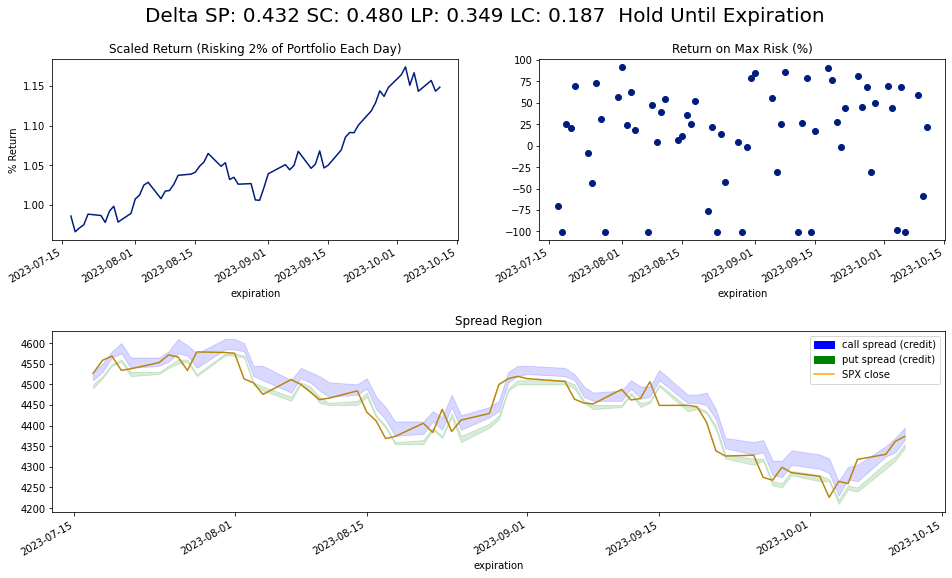

In [11]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [12]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [13]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-10-11,2023-10-12,0.43239,4365.0,0.402192,1125.0,0.479904,4380.0,0.453613,1550.0,0.187154,4415.0,0.165676,-360.0,0.349478,4355.0,0.311707,-810.0,4,1505.0


# Strikes following the 4/2 Strategy

In [14]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-10-11,2023-10-12,0.04,4285.0,0.039328,80.0,0.02,4455.0,0.019794,25.0,2,105.0
